# CUSTOMER SEGMENTATION

In this module, we use ***Online retail*** dataset which is kind of transactional dataset. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

In this model, we aimed to calculate the customers based on RFM so that company can target its customer efficiently.

## STEPS FOLLOW IN THIS MODEL ##

1. Understanding the dataset
2. Data Cleaning
3. Data Preparation
4. Model Building
5. Final Analysis

In [3]:
#----------------------------------STEP 01-----------------------------------#


#Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import sklearn 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score  #Silhouette Score
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import cut_tree



#Reading dataset
dataset = pd.read_csv("E:\\ML Zero to Hero\\OnlineRetail.csv\\OnlineRetail.csv", sep=",", encoding="ISO-8859-1", header=0)

#Analyzing dataset
print(dataset.head())
print(dataset.info())
print(dataset.describe())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

        InvoiceDate  UnitPrice  CustomerID         Country  
0  01-12-2010 08:26       2.55     17850.0  United Kingdom  
1  01-12-2010 08:26       3.39     17850.0  United Kingdom  
2  01-12-2010 08:26       2.75     17850.0  United Kingdom  
3  01-12-2010 08:26       3.39     17850.0  United Kingdom  
4  01-12-2010 08:26       3.39     17850.0  United Kingdom  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   

In [4]:
#----------------------------------STEP 02-----------------------------------#


#Finding null values
df_null = round(100*(dataset.isnull().sum())/len(dataset), 3)
print(df_null)
dataset=dataset.dropna()
print(dataset.shape)

#Changing customerID to str
dataset['CustomerID'] = dataset['CustomerID'].astype(str)


InvoiceNo       0.000
StockCode       0.000
Description     0.268
Quantity        0.000
InvoiceDate     0.000
UnitPrice       0.000
CustomerID     24.927
Country         0.000
dtype: float64
(406829, 8)


In [5]:
#---------------------------------STEP 03---------------------------------#

#As TotalAmount = Quantity * UnitPrice
dataset['Amount'] = dataset['Quantity'] * dataset['UnitPrice']

#Group customerID in ordr to computer total amount spend
TAS_1 = dataset.groupby('CustomerID')['Amount'].sum()

#Reset index
TAS_1 = TAS_1.reset_index()
TAS_1.head()

#Grouping customer ID and counting totl number of invoices
TAS_2 = dataset.groupby('CustomerID')['InvoiceNo'].count()

#Reset index
TAS_2 = TAS_2.reset_index()
TAS_2.columns = ['CustomerID', 'Frequency']
print(TAS_2.head())


#Merge two dataframes TAS_1 and TAS_2
TAS = pd.merge(TAS_1, TAS_2, on='CustomerID', how='inner')
print(TAS.head())


#Defining Recency attribute which store the difference of current date to the last date customer purchased something
#Convert data to proper format
dataset['InvoiceDate'] = pd.to_datetime(dataset['InvoiceDate'], format='%d-%m-%Y %H:%M')

#Finding max date
max_date = max(dataset['InvoiceDate'])

#Finding difference
dataset['Diff'] = max_date - dataset['InvoiceDate']

#Check dataset
print(dataset.head())

#Computing last transaction date
TAS_3 = dataset.groupby('CustomerID')['Diff'].min()
TAS_3 = TAS_3.reset_index()
TAS_3['Diff'] = TAS_3['Diff'].dt.days

#Mering dataframes
TAS = pd.merge(TAS, TAS_3, on='CustomerID', how='inner')
TAS.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']
TAS.head()

  CustomerID  Frequency
0    12346.0          2
1    12347.0        182
2    12348.0         31
3    12349.0         73
4    12350.0         17
  CustomerID   Amount  Frequency
0    12346.0     0.00          2
1    12347.0  4310.00        182
2    12348.0  1797.24         31
3    12349.0  1757.55         73
4    12350.0   334.40         17
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice CustomerID         Country  Amount  \
0 2010-12-01 08:26:00       2.55    17850.0  United Kingdom   15.30   
1 2010-12-01 08:26:00       3.39    17850.0  United Kingdom   20.34   
2 2010-12-01

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


Text(0.5, 0, 'Attributes')

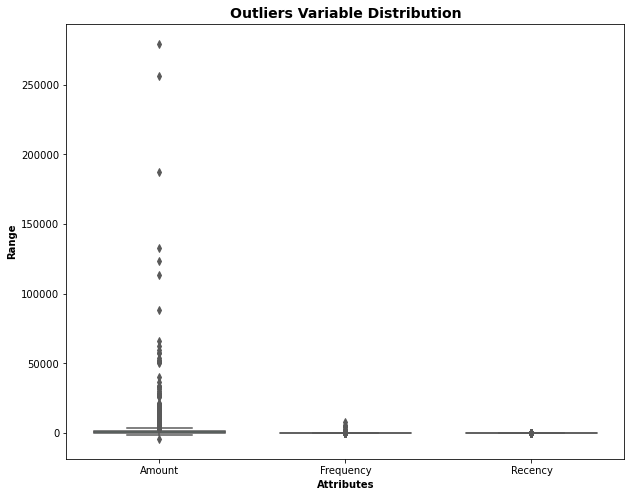

In [6]:
#-------------------------------------OUTLIER ANALYSIS--------------------------#

attributes = ['Amount', 'Frequency', 'Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data=TAS[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [7]:
# Using pd.quantile() that returns values at the given quantile over requested axis.

# Removing (statistical) outliers for Amount
Q1 = TAS.Amount.quantile(0.05)
Q3 = TAS.Amount.quantile(0.95)
IQR = Q3 - Q1
TAS = TAS[(TAS.Amount >= Q1 - 1.5*IQR) & (TAS.Amount <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Recency
Q1 = TAS.Recency.quantile(0.05)
Q3 = TAS.Recency.quantile(0.95)
IQR = Q3 - Q1
TAS = TAS[(TAS.Recency >= Q1 - 1.5*IQR) & (TAS.Recency <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Frequency
Q1 = TAS.Frequency.quantile(0.05)
Q3 = TAS.Frequency.quantile(0.95)
IQR = Q3 - Q1
TAS = TAS[(TAS.Frequency >= Q1 - 1.5*IQR) & (TAS.Frequency <= Q3 + 1.5*IQR)]


#Resclaing attributes
TAS_N = TAS[['Amount', 'Frequency', 'Recency']]

#Scaling features
scaler = StandardScaler()
TAS_N = scaler.fit_transform(TAS_N)
print(TAS_N.shape)

TAS_N = pd.DataFrame(TAS_N)
TAS_N.columns = ['Amount', 'Frequency', 'Recency']
TAS_N.head()

(4293, 3)


,Amount,Frequency,Recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


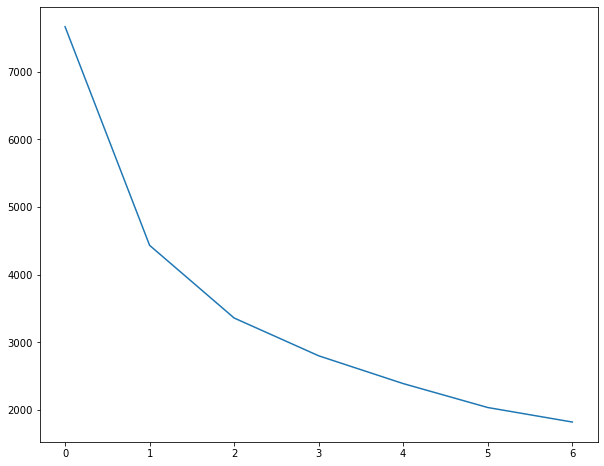

In [8]:
#------------------------------------STEP 4-------------------------------------#

#KMean with some arbitrary k
kmeans = KMeans(n_clusters = 4, max_iter=50)
kmeans.fit(TAS_N)
kmeans.labels_


#Getting optimal number of clusters
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(TAS_N)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(ssd)

In [9]:
#-----------------------------LETS PERFORM SILHOUETTE ANALYSIS------------------------------------#

range_n_cluster = [2,3,4,5,6,7,8]
for num_cluster in range_n_cluster:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(TAS_N)
    
    cluster_label = kmeans.labels_
    silhouette_avg = silhouette_score(TAS_N, cluster_label)
    
    print("For clusters = {0}, the silhouette score is {1}".format(num_cluster, silhouette_avg))

For clusters = 2, the silhouette score is 0.39983440871852094
For clusters = 3, the silhouette score is 0.40988697750698017
For clusters = 4, the silhouette score is 0.4034355228965416
For clusters = 5, the silhouette score is 0.40566554522987425
For clusters = 6, the silhouette score is 0.4119913645498276
For clusters = 7, the silhouette score is 0.3940509153118795
For clusters = 8, the silhouette score is 0.390807932338238


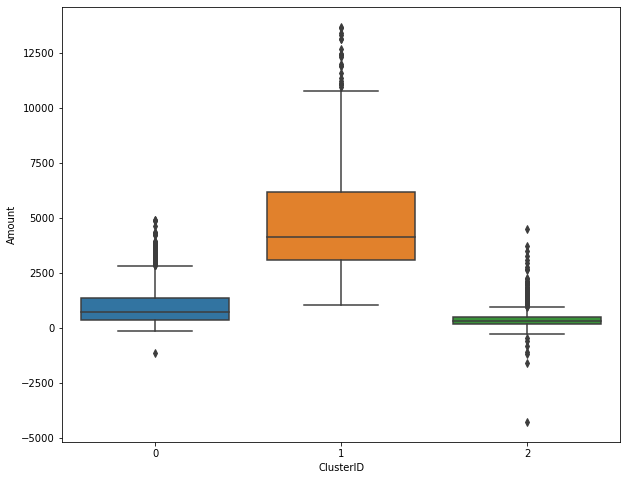

In [10]:
#Defining final model
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(TAS_N)

#Assign the label
TAS['ClusterID'] = kmeans.labels_

#Visualizing ClusterID vs Amount using boxplot
sns.boxplot(x='ClusterID', y='Amount', data=TAS)


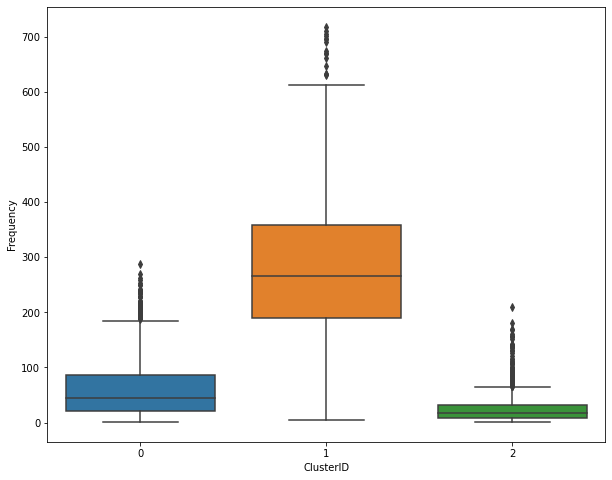

In [11]:
#Visualizing ClusterID vs Amount using boxplot
sns.boxplot(x='ClusterID', y='Frequency', data=TAS)


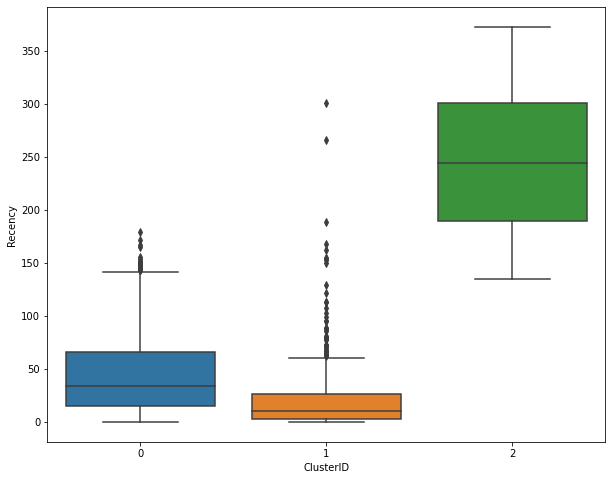

In [12]:
#Visualizing ClusterID vs Amount using boxplot
sns.boxplot(x='ClusterID', y='Recency', data=TAS)

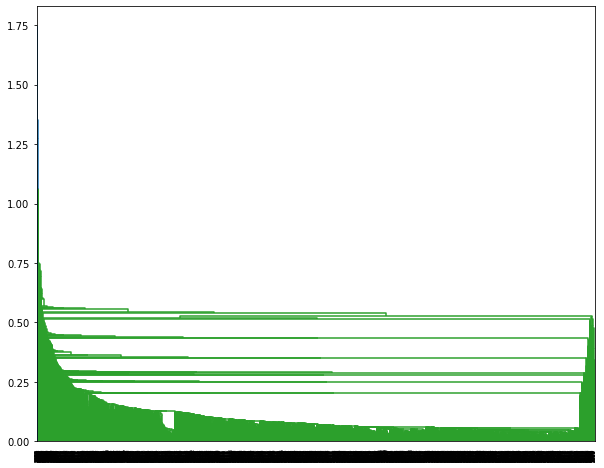

In [13]:
#-----HEIRARCHICAL CLUSTERIN-----------#

#Single Linkage
mergings = linkage(TAS_N, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()


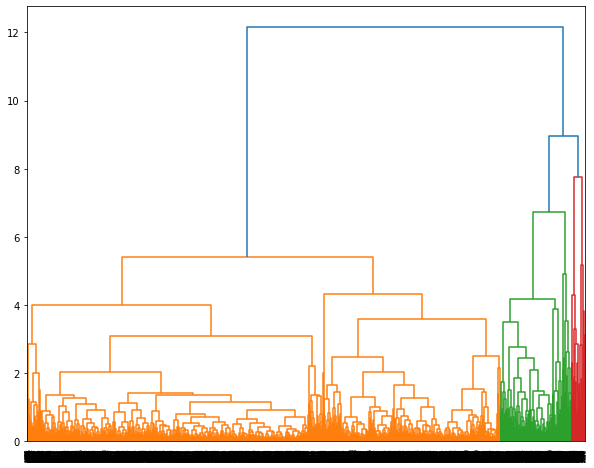

In [14]:
#Complete Linkage
mergings = linkage(TAS_N, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

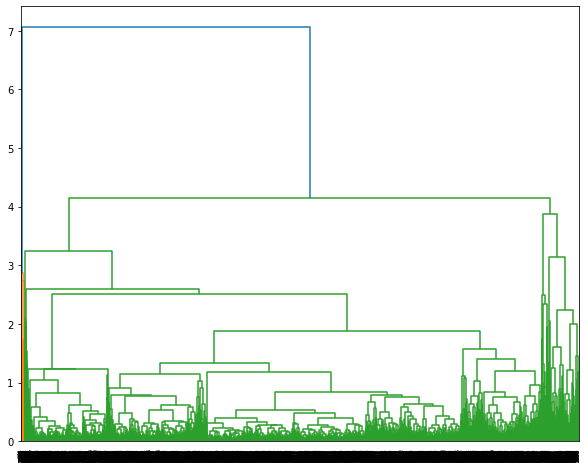

In [15]:
# Average linkage

mergings = linkage(TAS_N, method="average", metric='euclidean')
dendrogram(mergings)
plt.show()

In [17]:
#Clustering thhe dendrogram based on k
cluster_labels = cut_tree(mergings, n_clusters = 3).reshape(-1, )
cluster_labels

array([0, 0, 0, ..., 0, 0, 0])

In [18]:
#Assign cluster label 

TAS['cluster_labels'] = cluster_labels
TAS.head()

,CustomerID,Amount,Frequency,Recency,ClusterID,cluster_labels
0,12346.0,0.00,2,325,2,0
1,12347.0,4310.00,182,1,1,0
2,12348.0,1797.24,31,74,0,0
3,12349.0,1757.55,73,18,0,0
4,12350.0,334.40,17,309,2,0


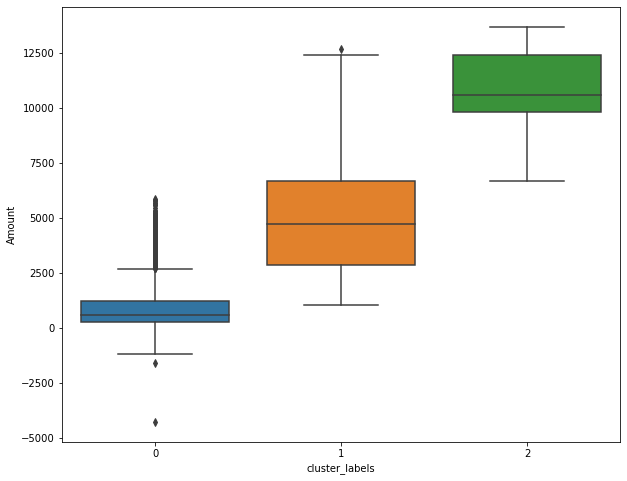

In [19]:
#Plot ClusterID vs Amount

sns.boxplot(x='cluster_labels', y='Amount', data=TAS)

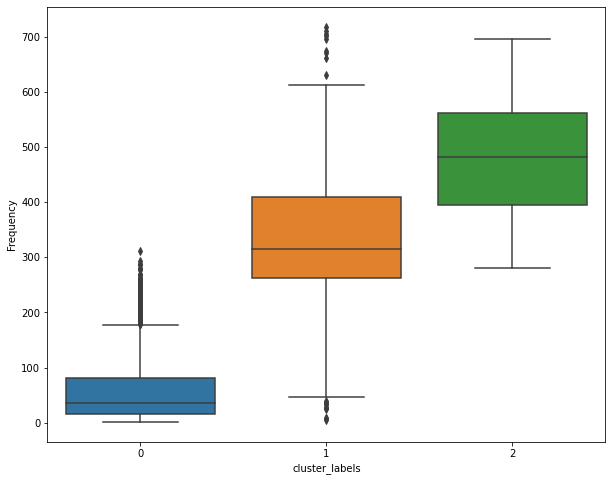

In [20]:
#Plot ClusterID vs Frequency

sns.boxplot(x='cluster_labels', y='Frequency', data=TAS)

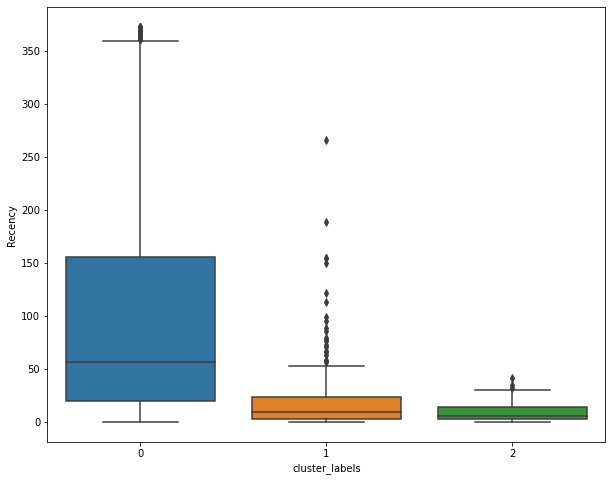

In [21]:
#Plot ClusterID vs Recency

sns.boxplot(x='cluster_labels', y='Recency', data=TAS)

In [22]:
#---------------------------------STEP 5---------------------------------#
#Draw analysis on the basis of following factors 

### Inference:
**K-Means Clustering with 3 Cluster Ids**
- Customers with Cluster Id 1 are the customers with high amount of transactions as compared to other customers.
- Customers with Cluster Id 1 are frequent buyers.
- Customers with Cluster Id 2 are not recent buyers and hence least of importance from business point of view.

**Hierarchical Clustering with 3 Cluster Labels**
- Customers with Cluster_Labels 2 are the customers with high amount of transactions as compared to other customers.
- Customers with Cluster_Labels 2 are frequent buyers.
- Customers with Cluster_Labels 0 are not recent buyers and hence least of importance from business point of view.